In [1]:
%reset -f

In [2]:
import os
import math
import pandas as pd
import matplotlib.pyplot as plt

### Read data

In [3]:
def read_data(data_dir):
    data = []  # List to store (benchmark, IPC value) tuples
    for file in os.listdir(data_dir):
        if file.endswith(".txt"):

            if os.path.getsize(os.path.join(data_dir, file)) == 0:
                print(f"File {file} is empty, directory: {data_dir}, skipping...")
                continue

            with open(os.path.join(data_dir, file), "r") as f:
                for line in f:
                    if "CPU 0 cumulative IPC:" in line:
                        try:
                            # Extract the IPC value
                            ipc_value = float(
                                line.split("CPU 0 cumulative IPC:")[1].split()[0]
                            )
                            # Append to list
                            data.append((file.split(".txt")[0], ipc_value))
                        except (IndexError, ValueError):
                            print(f"Couldn't extract IPC value from line: {line}")

    # Create DataFrame from the data
    df = pd.DataFrame(data, columns=["Benchmark", "IPC"])

    # Sort the DataFrame by Benchmark name
    df = df.sort_values(by=["Benchmark"])
    df = df.reset_index(drop=True)

    return df

In [4]:
cp_ipc_df = read_data("cp-data")
wp_ipc_df = read_data("wp-data")

In [5]:
def group_by_instr_prefetcher(main_df, instr_prefetcher):
    df = main_df[
        main_df["Benchmark"].str.contains(f"champsim-{instr_prefetcher}$", regex=True)
    ].reset_index(drop=True)
    df["Benchmark"] = df["Benchmark"].str.replace(f"-champsim-{instr_prefetcher}", "")

    # Calculate Geometric Mean
    geomean = math.prod(df["IPC"]) ** (1 / len(df["IPC"]))
    geomean_df = pd.DataFrame([{"Benchmark": "Geomean", "IPC": geomean}])
    df = pd.concat([df, geomean_df], ignore_index=True)

    return df

In [6]:
def calculate_speedup(df, baseline_df):
    df["Speedup"] = ((df["IPC"] / baseline_df["IPC"]) - 1) * 100
    return df

## L1I

### Correct Path

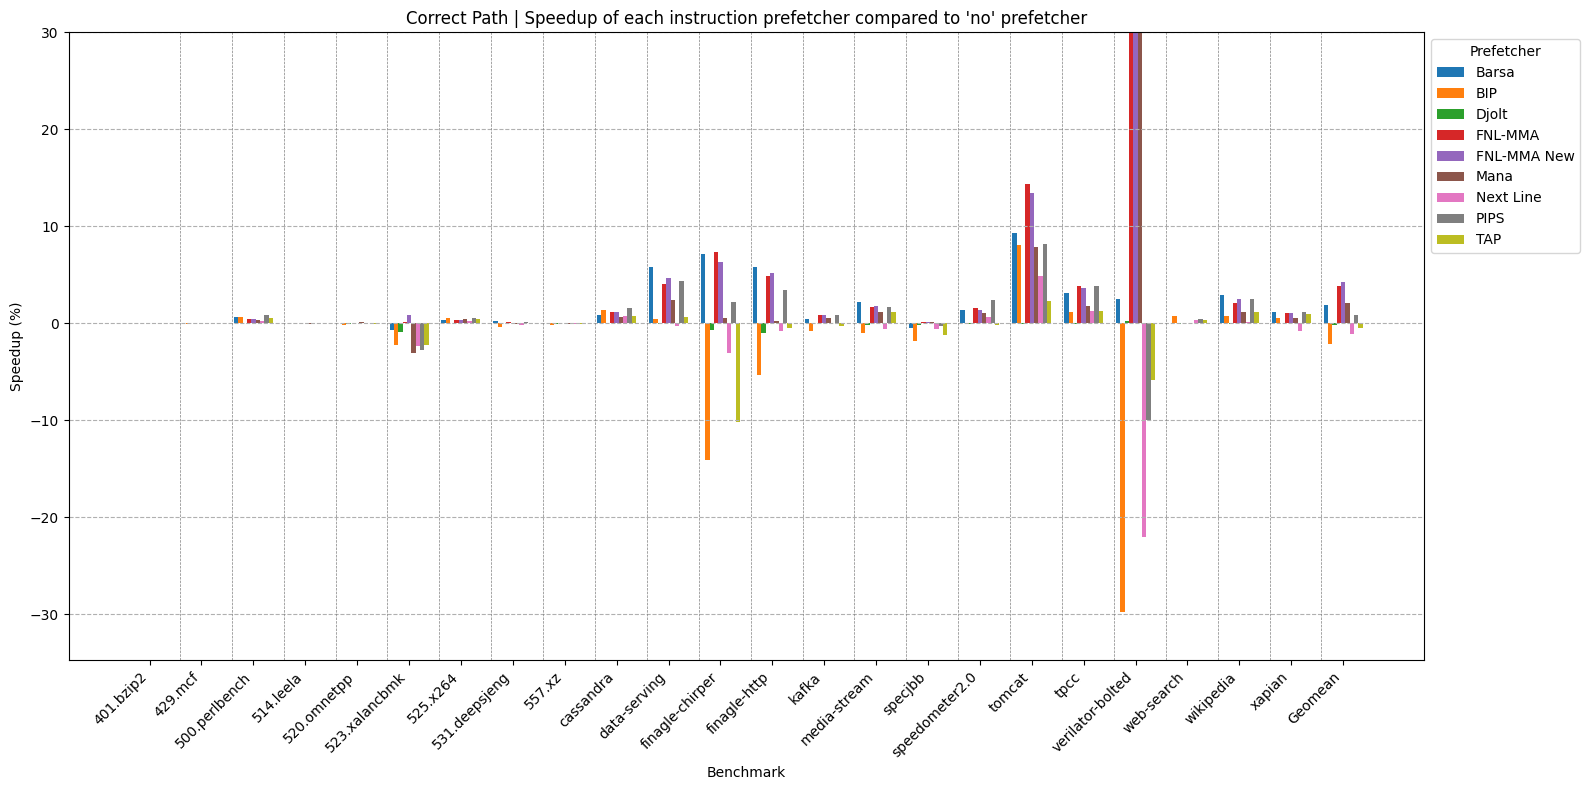

In [7]:
df_cp_no = group_by_instr_prefetcher(cp_ipc_df, "no")
df_cp_barsa = group_by_instr_prefetcher(cp_ipc_df, "barsa")
df_cp_bip = group_by_instr_prefetcher(cp_ipc_df, "bip")
df_cp_djolt = group_by_instr_prefetcher(cp_ipc_df, "djolt")
df_cp_fnlmma = group_by_instr_prefetcher(cp_ipc_df, "fnlmma")
df_cp_fnlmma_new = group_by_instr_prefetcher(cp_ipc_df, "fnlmma_new")
df_cp_mana = group_by_instr_prefetcher(cp_ipc_df, "mana")
df_cp_next_line = group_by_instr_prefetcher(cp_ipc_df, "next_line")
df_cp_pips = group_by_instr_prefetcher(cp_ipc_df, "pips")
df_cp_tap = group_by_instr_prefetcher(cp_ipc_df, "tap")

df_cp_barsa = calculate_speedup(df_cp_barsa, df_cp_no)
df_cp_bip = calculate_speedup(df_cp_bip, df_cp_no)
df_cp_djolt = calculate_speedup(df_cp_djolt, df_cp_no)
df_cp_fnlmma = calculate_speedup(df_cp_fnlmma, df_cp_no)
df_cp_fnlmma_new = calculate_speedup(df_cp_fnlmma_new, df_cp_no)
df_cp_mana = calculate_speedup(df_cp_mana, df_cp_no)
df_cp_next_line = calculate_speedup(df_cp_next_line, df_cp_no)
df_cp_pips = calculate_speedup(df_cp_pips, df_cp_no)
df_cp_tap = calculate_speedup(df_cp_tap, df_cp_no)

# Bar width
bar_width = 0.1
gap = 0.2

# Positions of the bars on the x-axis
r1 = [x * (1 + gap) for x in range(len(df_cp_no))]
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
r4 = [x + bar_width for x in r3]
r5 = [x + bar_width for x in r4]
r6 = [x + bar_width for x in r5]
r7 = [x + bar_width for x in r6]
r8 = [x + bar_width for x in r7]
r9 = [x + bar_width for x in r8]

# Create the bars
plt.figure(figsize=(16, 8))
plt.bar(r1, df_cp_barsa["Speedup"], width=bar_width, label="Barsa")
plt.bar(r2, df_cp_bip["Speedup"], width=bar_width, label="BIP")
plt.bar(r3, df_cp_djolt["Speedup"], width=bar_width, label="Djolt")
plt.bar(r4, df_cp_fnlmma["Speedup"], width=bar_width, label="FNL-MMA")
plt.bar(r5, df_cp_fnlmma_new["Speedup"], width=bar_width, label="FNL-MMA New")
plt.bar(r6, df_cp_mana["Speedup"], width=bar_width, label="Mana")
plt.bar(r7, df_cp_next_line["Speedup"], width=bar_width, label="Next Line")
plt.bar(r8, df_cp_pips["Speedup"], width=bar_width, label="PIPS")
plt.bar(r9, df_cp_tap["Speedup"], width=bar_width, label="TAP")

# Add shorter vertical dashed lines between each group
for i in range(1, len(df_cp_barsa)):
    plt.axvline(x=(r1[i] - gap / 2), color="gray", linestyle="--", linewidth=0.5)


# Add labels and title
plt.grid(axis="y", linestyle="--")
plt.xticks(
    [r + 4 * bar_width for r in r1], df_cp_barsa["Benchmark"], rotation=45, ha="right"
)
plt.xlabel("Benchmark")
plt.ylabel("Speedup (%)")
plt.ylim(top=30)
plt.legend(title="Prefetcher", bbox_to_anchor=(1, 1), loc="upper left")
plt.title(
    "Correct Path | Speedup of each instruction prefetcher compared to 'no' prefetcher"
)
plt.tight_layout()
plt.show()

### Wrong Path

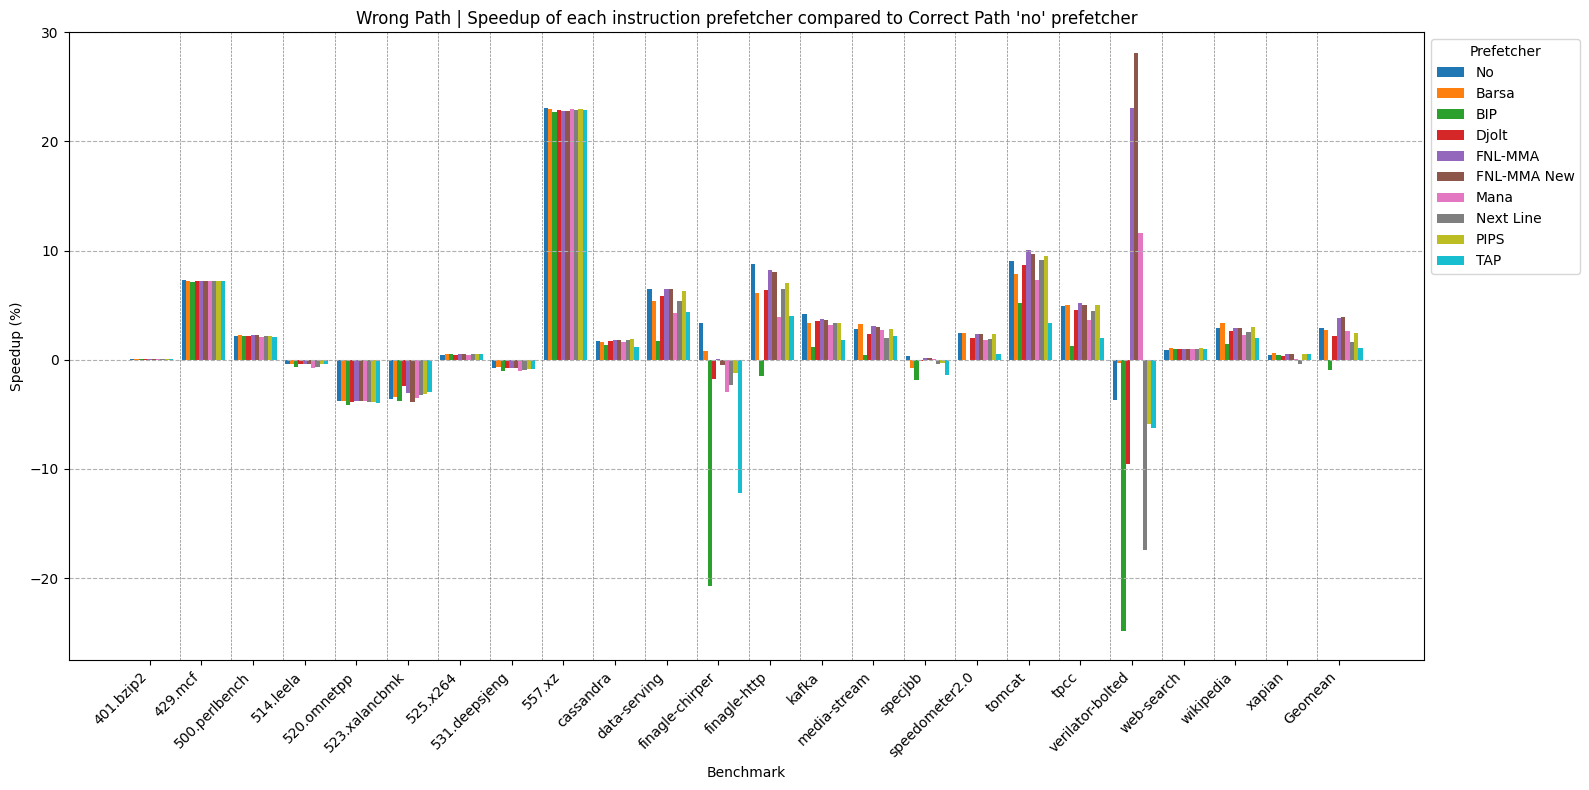

In [8]:
df_wp_no = group_by_instr_prefetcher(wp_ipc_df, "no")
df_wp_barsa = group_by_instr_prefetcher(wp_ipc_df, "barsa")
df_wp_bip = group_by_instr_prefetcher(wp_ipc_df, "bip")
df_wp_djolt = group_by_instr_prefetcher(wp_ipc_df, "djolt")
df_wp_fnlmma = group_by_instr_prefetcher(wp_ipc_df, "fnlmma")
df_wp_fnlmma_new = group_by_instr_prefetcher(wp_ipc_df, "fnlmma_new")
df_wp_mana = group_by_instr_prefetcher(wp_ipc_df, "mana")
df_wp_next_line = group_by_instr_prefetcher(wp_ipc_df, "next_line")
df_wp_pips = group_by_instr_prefetcher(wp_ipc_df, "pips")
df_wp_tap = group_by_instr_prefetcher(wp_ipc_df, "tap")

df_wp_no = calculate_speedup(df_wp_no, df_cp_no)
df_wp_barsa = calculate_speedup(df_wp_barsa, df_cp_no)
df_wp_bip = calculate_speedup(df_wp_bip, df_cp_no)
df_wp_djolt = calculate_speedup(df_wp_djolt, df_cp_no)
df_wp_fnlmma = calculate_speedup(df_wp_fnlmma, df_cp_no)
df_wp_fnlmma_new = calculate_speedup(df_wp_fnlmma_new, df_cp_no)
df_wp_mana = calculate_speedup(df_wp_mana, df_cp_no)
df_wp_next_line = calculate_speedup(df_wp_next_line, df_cp_no)
df_wp_pips = calculate_speedup(df_wp_pips, df_cp_no)
df_wp_tap = calculate_speedup(df_wp_tap, df_cp_no)

# Bar width
bar_width = 0.1
gap = 0.2

# Positions of the bars on the x-axis
r1 = [x * (1 + gap) for x in range(len(df_wp_no))]
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
r4 = [x + bar_width for x in r3]
r5 = [x + bar_width for x in r4]
r6 = [x + bar_width for x in r5]
r7 = [x + bar_width for x in r6]
r8 = [x + bar_width for x in r7]
r9 = [x + bar_width for x in r8]
r10 = [x + bar_width for x in r9]

# Create the bars
plt.figure(figsize=(16, 8))
plt.bar(r1, df_wp_no["Speedup"], width=bar_width, label="No")
plt.bar(r2, df_wp_barsa["Speedup"], width=bar_width, label="Barsa")
plt.bar(r3, df_wp_bip["Speedup"], width=bar_width, label="BIP")
plt.bar(r4, df_wp_djolt["Speedup"], width=bar_width, label="Djolt")
plt.bar(r5, df_wp_fnlmma["Speedup"], width=bar_width, label="FNL-MMA")
plt.bar(r6, df_wp_fnlmma_new["Speedup"], width=bar_width, label="FNL-MMA New")
plt.bar(r7, df_wp_mana["Speedup"], width=bar_width, label="Mana")
plt.bar(r8, df_wp_next_line["Speedup"], width=bar_width, label="Next Line")
plt.bar(r9, df_wp_pips["Speedup"], width=bar_width, label="PIPS")
plt.bar(r10, df_wp_tap["Speedup"], width=bar_width, label="TAP")

# Add shorter vertical dashed lines between each group
for i in range(1, len(df_wp_no)):
    plt.axvline(x=(r1[i] - gap / 2), color="gray", linestyle="--", linewidth=0.5)

# Add labels and title
plt.grid(axis="y", linestyle="--")
plt.xticks(
    [r + 4 * bar_width for r in r1], df_wp_no["Benchmark"], rotation=45, ha="right"
)
plt.xlabel("Benchmark")
plt.ylabel("Speedup (%)")
plt.ylim(top=30)
plt.legend(title="Prefetcher", bbox_to_anchor=(1, 1), loc="upper left")
plt.title(
    "Wrong Path | Speedup of each instruction prefetcher compared to Correct Path 'no' prefetcher"
)
plt.tight_layout()
plt.show()

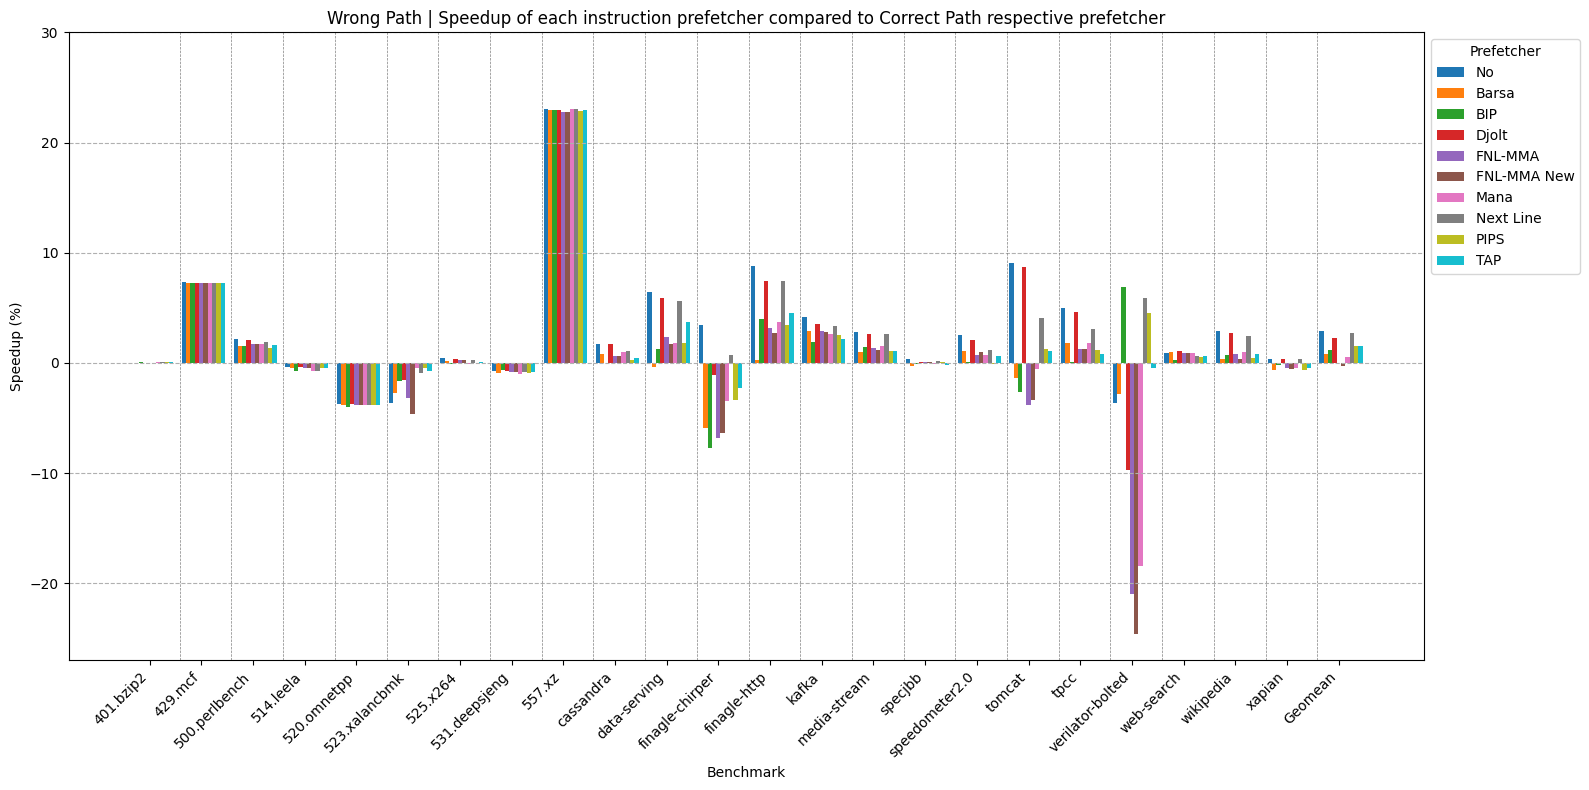

In [9]:
df_wp_no = group_by_instr_prefetcher(wp_ipc_df, "no")
df_wp_barsa = group_by_instr_prefetcher(wp_ipc_df, "barsa")
df_wp_bip = group_by_instr_prefetcher(wp_ipc_df, "bip")
df_wp_djolt = group_by_instr_prefetcher(wp_ipc_df, "djolt")
df_wp_fnlmma = group_by_instr_prefetcher(wp_ipc_df, "fnlmma")
df_wp_fnlmma_new = group_by_instr_prefetcher(wp_ipc_df, "fnlmma_new")
df_wp_mana = group_by_instr_prefetcher(wp_ipc_df, "mana")
df_wp_next_line = group_by_instr_prefetcher(wp_ipc_df, "next_line")
df_wp_pips = group_by_instr_prefetcher(wp_ipc_df, "pips")
df_wp_tap = group_by_instr_prefetcher(wp_ipc_df, "tap")

df_wp_no = calculate_speedup(df_wp_no, df_cp_no)
df_wp_barsa = calculate_speedup(df_wp_barsa, df_cp_barsa)
df_wp_bip = calculate_speedup(df_wp_bip, df_cp_bip)
df_wp_djolt = calculate_speedup(df_wp_djolt, df_cp_djolt)
df_wp_fnlmma = calculate_speedup(df_wp_fnlmma, df_cp_fnlmma)
df_wp_fnlmma_new = calculate_speedup(df_wp_fnlmma_new, df_cp_fnlmma_new)
df_wp_mana = calculate_speedup(df_wp_mana, df_cp_mana)
df_wp_next_line = calculate_speedup(df_wp_next_line, df_cp_next_line)
df_wp_pips = calculate_speedup(df_wp_pips, df_cp_pips)
df_wp_tap = calculate_speedup(df_wp_tap, df_cp_tap)

# Bar width
bar_width = 0.1
gap = 0.2

# Positions of the bars on the x-axis
r1 = [x * (1 + gap) for x in range(len(df_wp_no))]
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
r4 = [x + bar_width for x in r3]
r5 = [x + bar_width for x in r4]
r6 = [x + bar_width for x in r5]
r7 = [x + bar_width for x in r6]
r8 = [x + bar_width for x in r7]
r9 = [x + bar_width for x in r8]
r10 = [x + bar_width for x in r9]

# Create the bars
plt.figure(figsize=(16, 8))
plt.bar(r1, df_wp_no["Speedup"], width=bar_width, label="No")
plt.bar(r2, df_wp_barsa["Speedup"], width=bar_width, label="Barsa")
plt.bar(r3, df_wp_bip["Speedup"], width=bar_width, label="BIP")
plt.bar(r4, df_wp_djolt["Speedup"], width=bar_width, label="Djolt")
plt.bar(r5, df_wp_fnlmma["Speedup"], width=bar_width, label="FNL-MMA")
plt.bar(r6, df_wp_fnlmma_new["Speedup"], width=bar_width, label="FNL-MMA New")
plt.bar(r7, df_wp_mana["Speedup"], width=bar_width, label="Mana")
plt.bar(r8, df_wp_next_line["Speedup"], width=bar_width, label="Next Line")
plt.bar(r9, df_wp_pips["Speedup"], width=bar_width, label="PIPS")
plt.bar(r10, df_wp_tap["Speedup"], width=bar_width, label="TAP")

# Add shorter vertical dashed lines between each group
for i in range(1, len(df_wp_no)):
    plt.axvline(x=(r1[i] - gap / 2), color="gray", linestyle="--", linewidth=0.5)

# Add labels and title
plt.grid(axis="y", linestyle="--")
plt.xticks(
    [r + 4 * bar_width for r in r1], df_wp_no["Benchmark"], rotation=45, ha="right"
)
plt.xlabel("Benchmark")
plt.ylabel("Speedup (%)")
plt.ylim(top=30)
plt.legend(title="Prefetcher", bbox_to_anchor=(1, 1), loc="upper left")
plt.title(
    "Wrong Path | Speedup of each instruction prefetcher compared to Correct Path respective prefetcher"
)
plt.tight_layout()
plt.show()

## L1D

### Correct Path

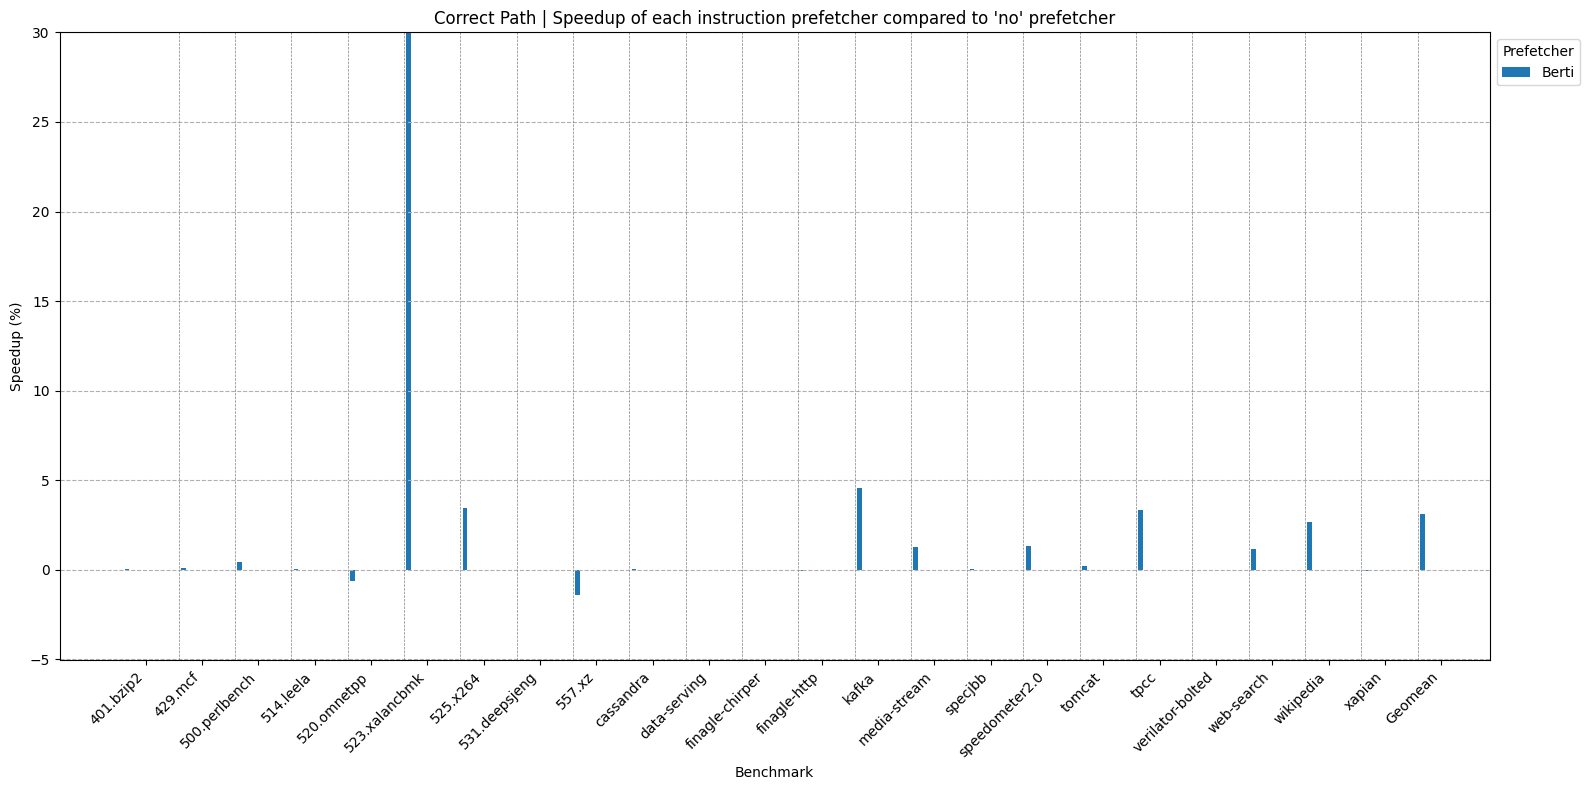

In [10]:
df_cp_no = group_by_instr_prefetcher(cp_ipc_df, "no")
df_cp_berti = group_by_instr_prefetcher(cp_ipc_df, "berti")

df_cp_berti = calculate_speedup(df_cp_berti, df_cp_no)

# Bar width
bar_width = 0.1
gap = 0.2

# Positions of the bars on the x-axis
r1 = [x * (1 + gap) for x in range(len(df_cp_no))]

# Create the bars
plt.figure(figsize=(16, 8))
plt.bar(r1, df_cp_berti["Speedup"], width=bar_width, label="Berti")

# Add shorter vertical dashed lines between each group
for i in range(1, len(df_cp_no)):
    plt.axvline(x=(r1[i] - gap / 2), color="gray", linestyle="--", linewidth=0.5)


# Add labels and title
plt.grid(axis="y", linestyle="--")
plt.xticks(
    [r + 4 * bar_width for r in r1], df_cp_no["Benchmark"], rotation=45, ha="right"
)
plt.xlabel("Benchmark")
plt.ylabel("Speedup (%)")
plt.ylim(top=30)
plt.legend(title="Prefetcher", bbox_to_anchor=(1, 1), loc="upper left")
plt.title(
    "Correct Path | Speedup of each instruction prefetcher compared to 'no' prefetcher"
)
plt.tight_layout()
plt.show()

### Wrong Path

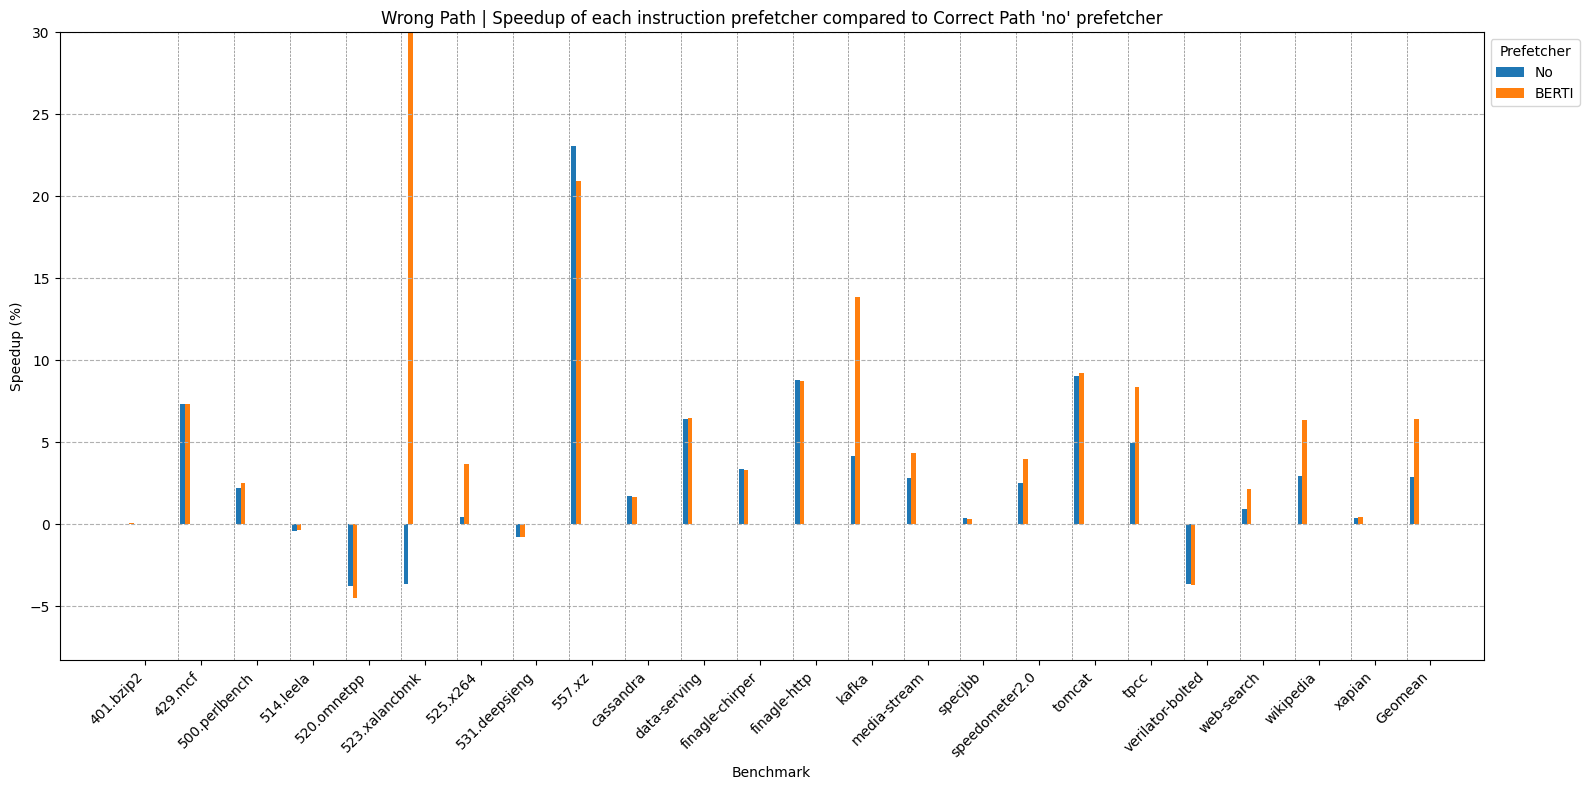

In [11]:
df_wp_no = group_by_instr_prefetcher(wp_ipc_df, "no")
df_wp_berti = group_by_instr_prefetcher(wp_ipc_df, "berti")

df_wp_no = calculate_speedup(df_wp_no, df_cp_no)
df_wp_berti = calculate_speedup(df_wp_berti, df_cp_no)

# Bar width
bar_width = 0.1
gap = 0.2

# Positions of the bars on the x-axis
r1 = [x * (1 + gap) for x in range(len(df_cp_no))]
r2 = [x + bar_width for x in r1]

# Create the bars
plt.figure(figsize=(16, 8))
plt.bar(r1, df_wp_no["Speedup"], width=bar_width, label="No")
plt.bar(r2, df_wp_berti["Speedup"], width=bar_width, label="BERTI")

# Add shorter vertical dashed lines between each group
for i in range(1, len(df_cp_no)):
    plt.axvline(x=(r1[i] - gap / 2), color="gray", linestyle="--", linewidth=0.5)

# Add labels and title
plt.grid(axis="y", linestyle="--")
plt.xticks(
    [r + 4 * bar_width for r in r1], df_wp_no["Benchmark"], rotation=45, ha="right"
)
plt.xlabel("Benchmark")
plt.ylabel("Speedup (%)")
plt.ylim(top=30)
plt.legend(title="Prefetcher", bbox_to_anchor=(1, 1), loc="upper left")
plt.title(
    "Wrong Path | Speedup of each instruction prefetcher compared to Correct Path 'no' prefetcher"
)
plt.tight_layout()
plt.show()

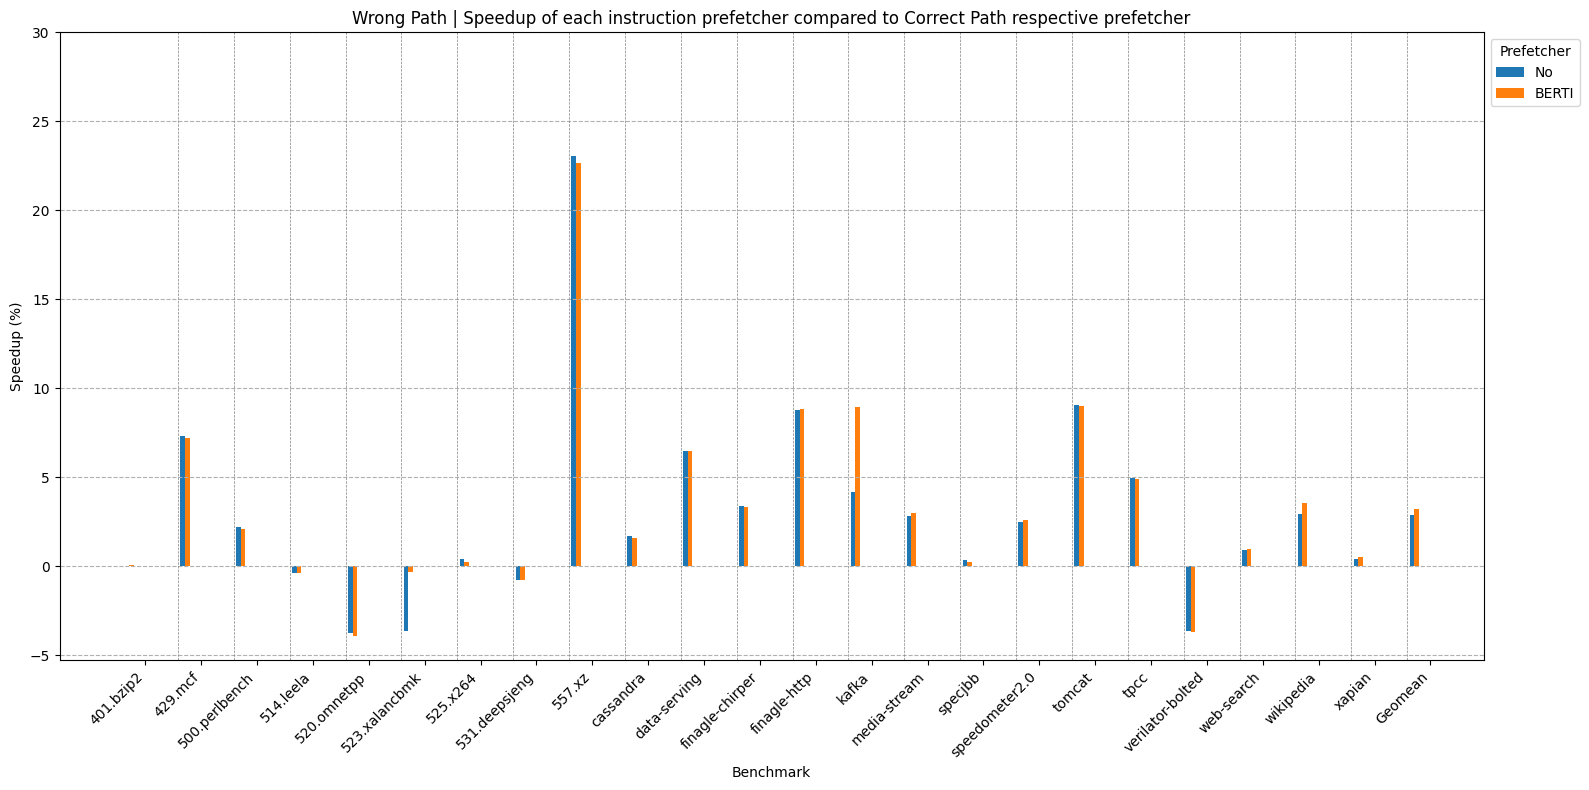

In [12]:
df_wp_no = group_by_instr_prefetcher(wp_ipc_df, "no")
df_wp_berti = group_by_instr_prefetcher(wp_ipc_df, "berti")

df_wp_no = calculate_speedup(df_wp_no, df_cp_no)
df_wp_berti = calculate_speedup(df_wp_berti, df_cp_berti)

# Bar width
bar_width = 0.1
gap = 0.2

# Positions of the bars on the x-axis
r1 = [x * (1 + gap) for x in range(len(df_wp_no))]
r11 = [x + bar_width for x in r10]

# Create the bars
plt.figure(figsize=(16, 8))
plt.bar(r1, df_wp_no["Speedup"], width=bar_width, label="No")
plt.bar(r2, df_wp_berti["Speedup"], width=bar_width, label="BERTI")

# Add shorter vertical dashed lines between each group
for i in range(1, len(df_wp_no)):
    plt.axvline(x=(r1[i] - gap / 2), color="gray", linestyle="--", linewidth=0.5)

# Add labels and title
plt.grid(axis="y", linestyle="--")
plt.xticks(
    [r + 4 * bar_width for r in r1], df_wp_no["Benchmark"], rotation=45, ha="right"
)
plt.xlabel("Benchmark")
plt.ylabel("Speedup (%)")
plt.ylim(top=30)
plt.legend(title="Prefetcher", bbox_to_anchor=(1, 1), loc="upper left")
plt.title(
    "Wrong Path | Speedup of each instruction prefetcher compared to Correct Path respective prefetcher"
)
plt.tight_layout()
plt.show()